In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
import backtrader as bt
import pyfolio as pf
from utils import read_data, BaseStrategy
%matplotlib inline

# Rob Hanna strategy

In [2]:
class TestStrategy(BaseStrategy):
    def __init__(self):
        self.rsi2_90 = bt.indicators.RSI(self.data0, period=2, safediv=True) > 90
        self.close_200 = self.data0.close > bt.indicators.SimpleMovingAverage(self.data0.close, period=200)
        
    def next(self):
        if self.position and len(self) >= (self.buy_executed + 2):
            self.sell(exectype=bt.Order.Market)
            self.buy_executed = None
        
        closes_down = self.data0.close[0] < self.data0.close[-1]
        if closes_down and self.rsi2_90 and self.close_200:
            self.buy(exectype=bt.Order.Market)
            self.buy_executed = len(self)
            self.log_candles()

In [3]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

# data = bt.feeds.YahooFinanceData(
#     dataname='SPY',
#     fromdate=datetime(2004,1,1),
#     todate=datetime(2018,1,1),
#     reverse=False, 
#     adjclose=False)
data = bt.feeds.PandasData(dataname=read_data('SPY_1993-2018.xls'), fromdate=datetime(2004,1,1))

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_coc(True)
cerebro.addsizer(bt.sizers.PercentSizer, percents=95)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2004-05-28, ===>
2004-05-28, Current Open: 112.3969, Close: 112.5265
2004-05-28, Next Open: 112.1277, Close: 112.3769
2004-06-01, BUY EXECUTED, 112.53
2004-06-03, SELL EXECUTED, 112.80
2004-10-29, ===>
2004-10-29, Current Open: 112.7857, Close: 112.8655
2004-10-29, Next Open: 113.2244, Close: 113.1746
2004-11-01, BUY EXECUTED, 112.87
2004-11-03, SELL EXECUTED, 113.21
2009-07-17, ===>
2009-07-17, Current Open: 94.06, Close: 94.13
2009-07-17, Next Open: 94.68, Close: 95.131
2009-07-20, BUY EXECUTED, 94.13
2009-07-22, SELL EXECUTED, 95.57
2009-07-22, ===>
2009-07-22, Current Open: 94.96, Close: 95.55
2009-07-22, Next Open: 95.61, Close: 97.661
2009-07-23, BUY EXECUTED, 95.55
2009-07-27, SELL EXECUTED, 98.06
2009-08-24, ===>
2009-08-24, Current Open: 103.39, Close: 102.96
2009-08-24, Next Open: 103.37, Close: 103.16
2009-08-25, BUY EXECUTED, 102.96
2009-08-27, SELL EXECUTED, 103.17
2009-09-11, ===>
2009-09-11, Current Open: 104.99, Close: 104.77
2009-09-

In [4]:
def prev_weekday(adate):
    adate -= timedelta(days=1)
    while adate.weekday() > 4: # Mon-Fri are 0-4
        adate -= timedelta(days=1)
    return adate.date()

In [5]:
temp_trans = transactions.copy()
temp_trans.index = temp_trans.index.map(lambda v: prev_weekday(v))

In [6]:
temp_trans

,amount,price,sid,symbol,value
date,,,,,
2004-05-31,844.245578,112.5265,0,,-95000.000000
2004-06-02,-844.245578,112.7957,0,,95227.270910
2004-10-29,842.021623,112.8655,0,,-95035.191457
2004-11-02,-842.021623,113.2145,0,,95329.057003
2009-07-17,1010.660976,94.1300,0,,-95133.517690
2009-07-21,-1010.660976,95.5700,0,,96588.869495
2009-07-22,1008.204769,95.5500,0,,-96333.965637
2009-07-24,-1008.204769,98.0600,0,,98864.559606
2009-08-24,957.193000,102.9600,0,,-98552.591309


Entire data start date: 2004-01-02
Entire data end date: 2018-01-09
Backtest months: 168


C:\DEV\Anaconda3\envs\trading\lib\site-packages\empyrical\stats.py:954: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


,Backtest
Annual return,0.4%
Cumulative returns,5.2%
Annual volatility,0.9%
Sharpe ratio,0.42
Calmar ratio,0.34
Stability,0.83
Max drawdown,-1.1%
Omega ratio,2.01
Sortino ratio,0.89
Skew,15.17


C:\DEV\Anaconda3\envs\trading\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.06,2009-09-15,2010-03-19,2012-02-07,626
1,1.01,2013-12-31,2014-01-03,2014-08-19,166
2,0.63,2016-07-14,2017-12-14,NaT,NaN
3,0.22,2004-05-28,2004-06-01,2004-06-02,4
4,0.20,2012-02-08,2013-12-30,2013-12-31,495


C:\DEV\Anaconda3\envs\trading\lib\site-packages\pyfolio\plotting.py:819: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  bmark_vol = factor_returns.loc[returns.index].std()
C:\DEV\Anaconda3\envs\trading\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


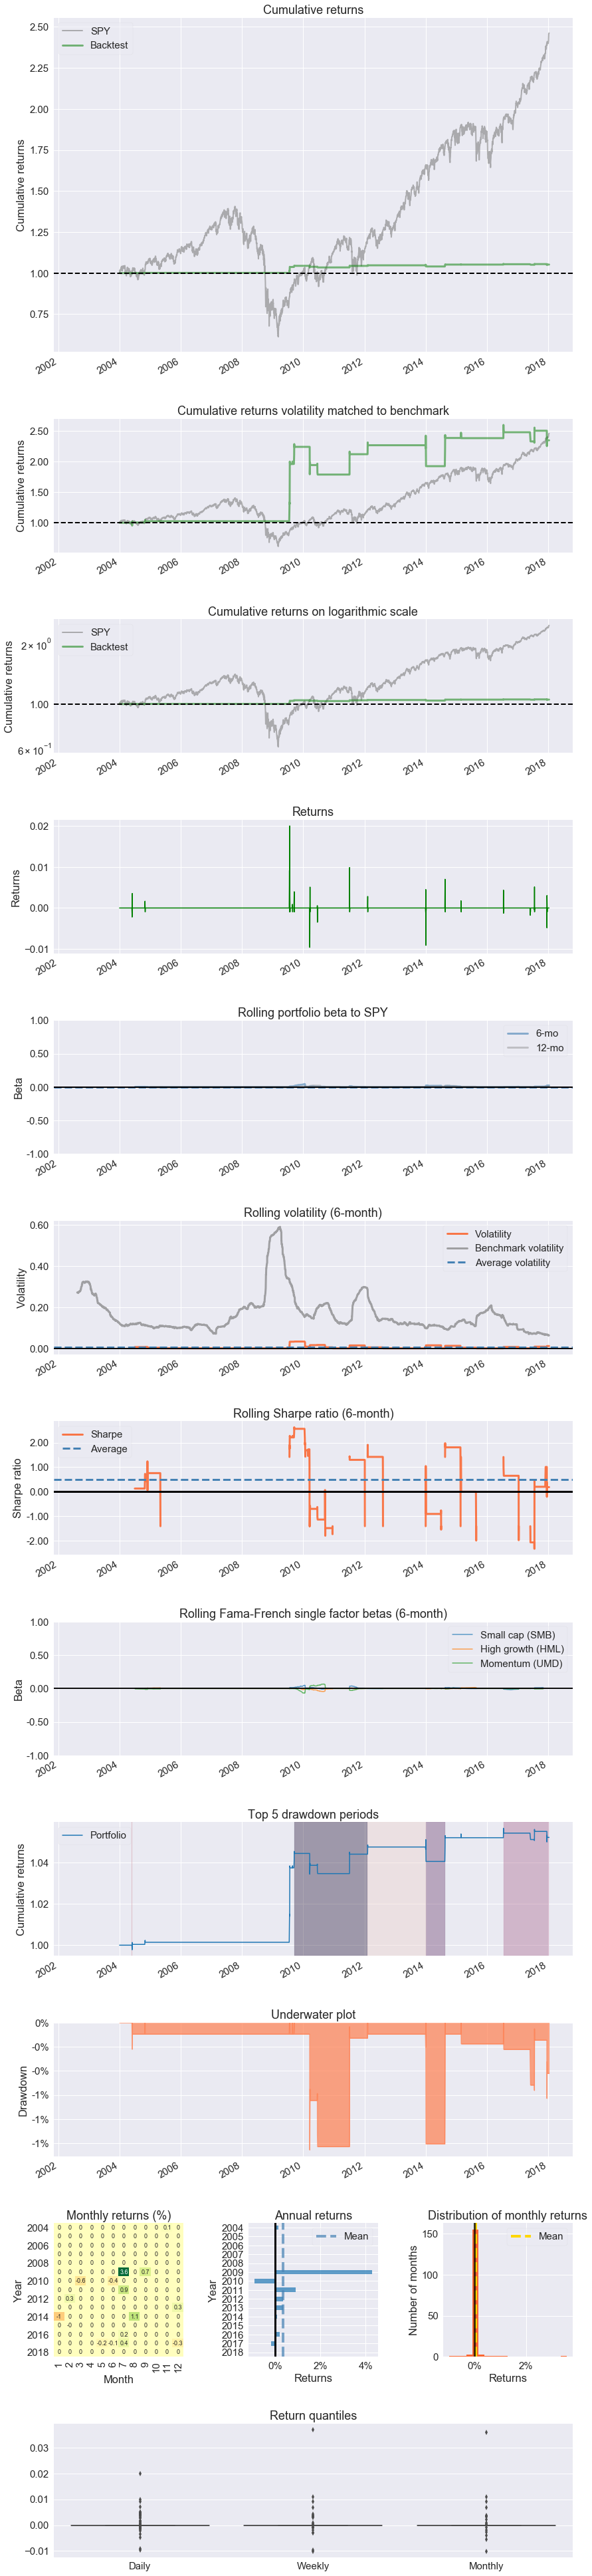

Stress Events,mean,min,max
Lehmann,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,0.00%,0.00%,0.00%
Fukushima,0.00%,0.00%,0.00%
EZB IR Event,0.00%,0.00%,0.00%
Aug07,0.00%,0.00%,0.00%
Mar08,0.00%,0.00%,0.00%
Sept08,0.00%,0.00%,0.00%
2009Q1,0.00%,0.00%,0.00%
2009Q2,0.00%,0.00%,0.00%
Flash Crash,0.00%,0.00%,0.00%


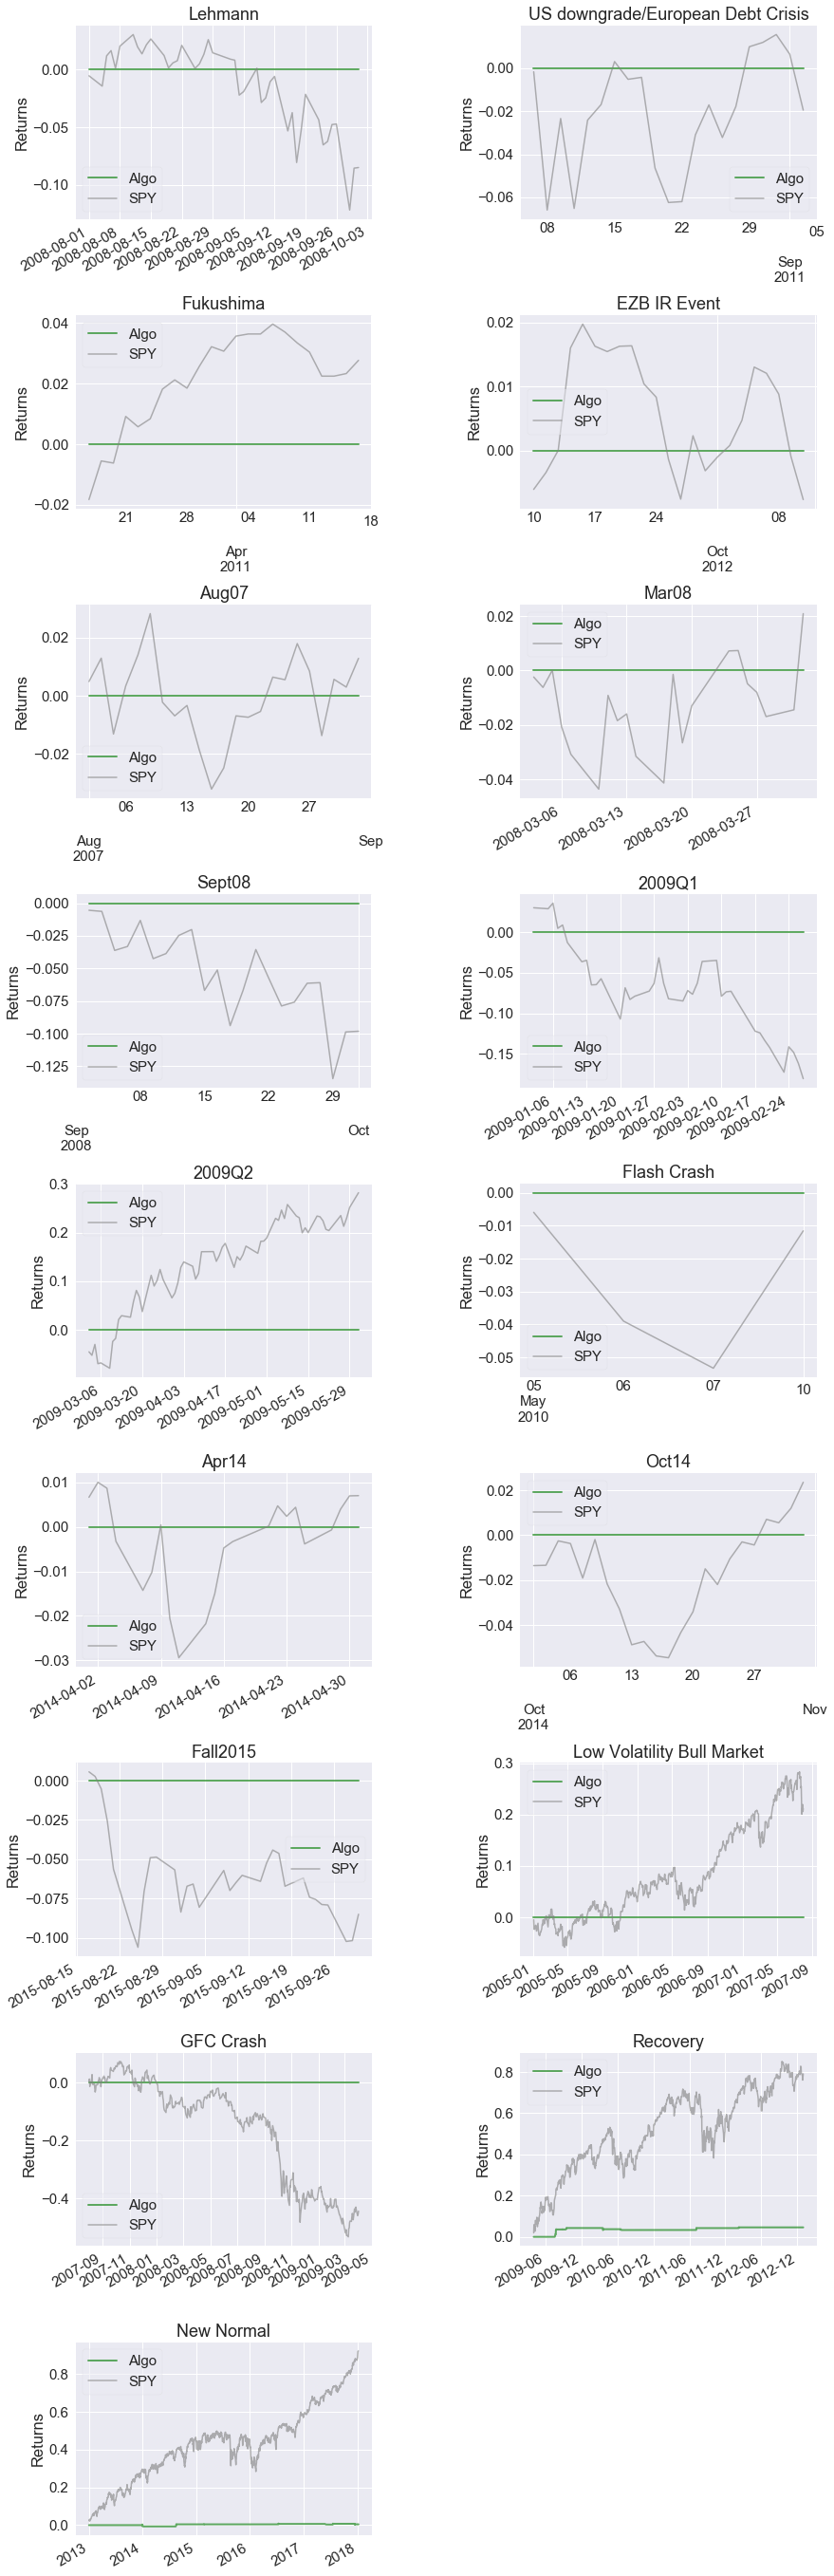

Top 10 long positions of all time,max
Data0,95.21%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Data0,95.21%


All positions ever held,max
Data0,95.21%


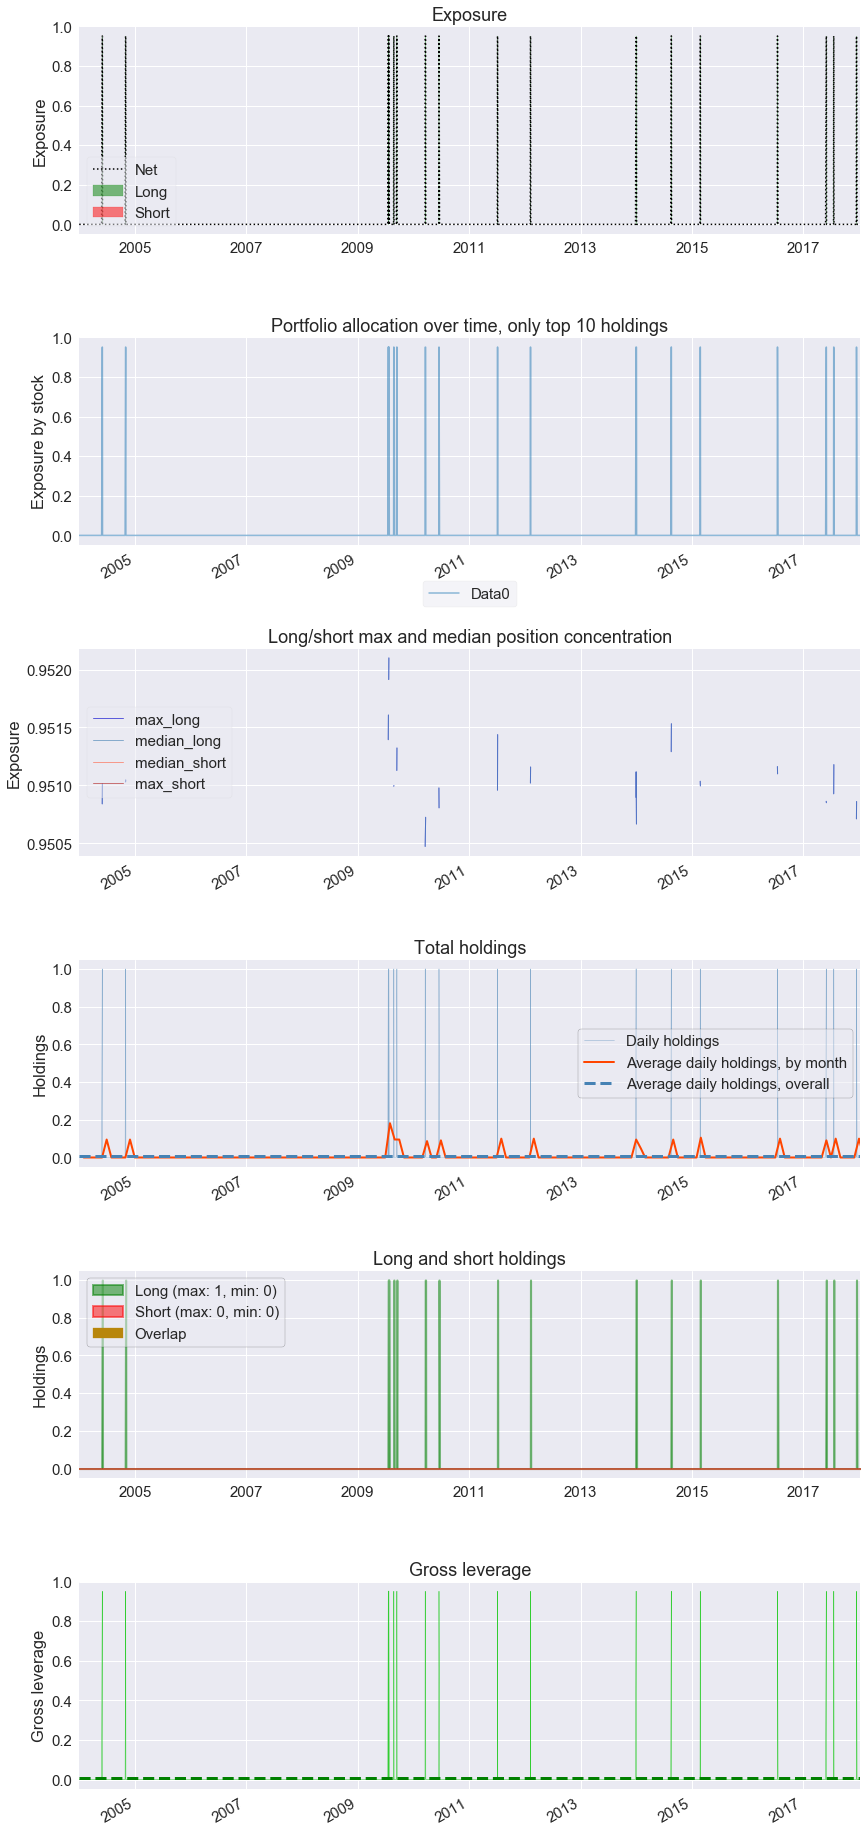

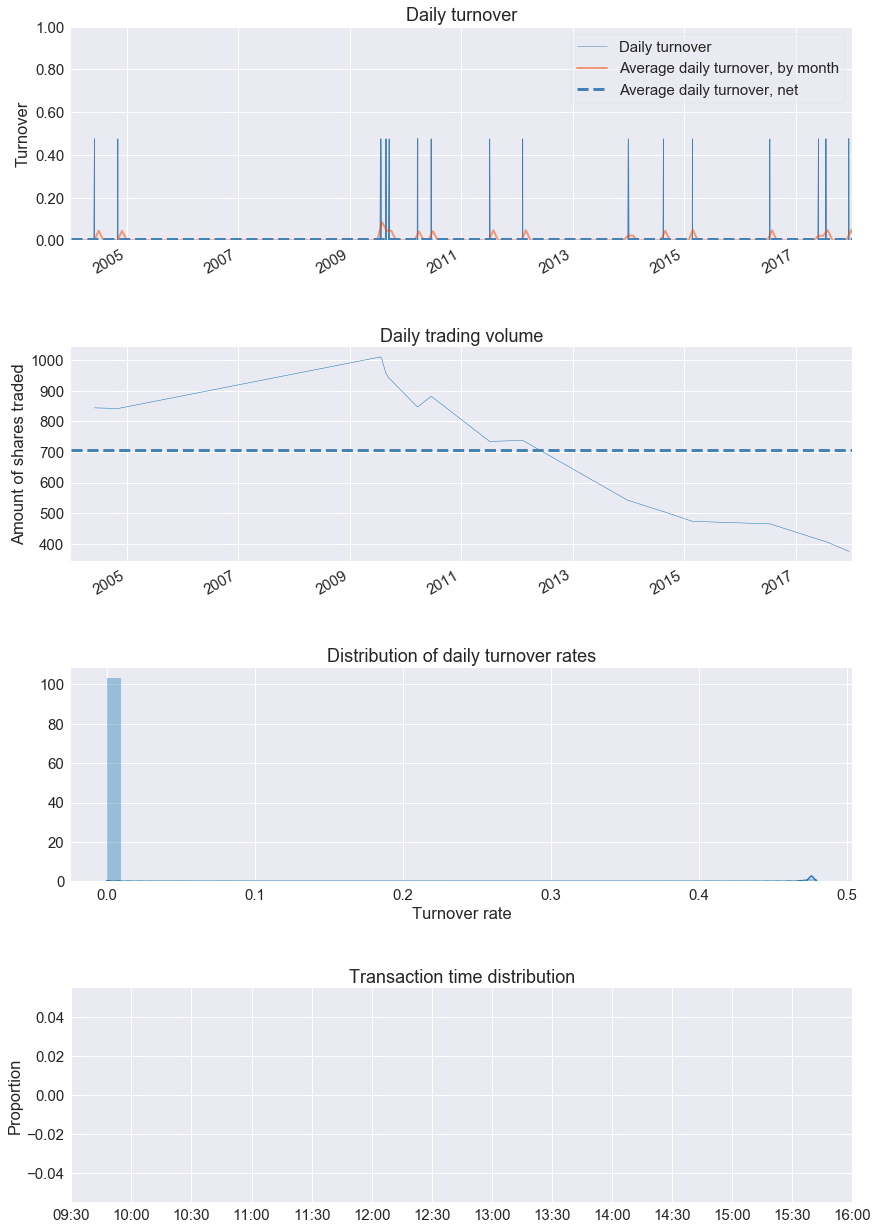

C:\DEV\Anaconda3\envs\trading\lib\site-packages\pyfolio\round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\pyfolio\round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
C:\DEV\Anaconda3\envs\trading\lib\site-packages\pyfolio\round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\pyfolio\round_trips.py:90: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
C:\DEV\Anaconda3\envs\trading\lib\site-packages\pyfolio\round_trips.py:379: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  round_trips.groupby('symbol')['returns']

Summary stats,All trades,Long trades
Total number of round_trips,17.00,17.00
Percent profitable,0.71,0.71
Winning round_trips,12.00,12.00
Losing round_trips,5.00,5.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$8563.35,$8563.35
Gross profit,$9845.99,$9845.99
Gross loss,$-1282.63,$-1282.63
Profit factor,$7.68,$7.68
Avg. trade net profit,$503.73,$503.73
Avg. winning trade,$820.50,$820.50
Avg. losing trade,$-256.53,$-256.53
Ratio Avg. Win:Avg. Loss,$3.20,$3.20
Largest winning trade,$2530.08,$2530.08
Largest losing trade,$-500.43,$-500.43


Duration stats,All trades,Long trades
Avg duration,2 days 16:56:28.235294,2 days 16:56:28.235294
Median duration,2 days 00:00:00,2 days 00:00:00
Longest duration,4 days 00:00:00,4 days 00:00:00
Shortest duration,2 days 00:00:00,2 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,0.49%,0.49%
Avg returns winning,0.79%,0.79%
Avg returns losing,-0.25%,-0.25%
Median returns all round_trips,0.29%,0.29%
Median returns winning,0.54%,0.54%
Median returns losing,-0.20%,-0.20%
Largest winning trade,2.44%,2.44%
Largest losing trade,-0.48%,-0.48%


Symbol stats,
Avg returns all round_trips,0.49%
Avg returns winning,0.79%
Avg returns losing,-0.25%
Median returns all round_trips,0.29%
Median returns winning,0.54%
Median returns losing,-0.20%
Largest winning trade,2.44%
Largest losing trade,-0.48%


Profitability (PnL / PnL total) per name,
symbol,
,100.00%


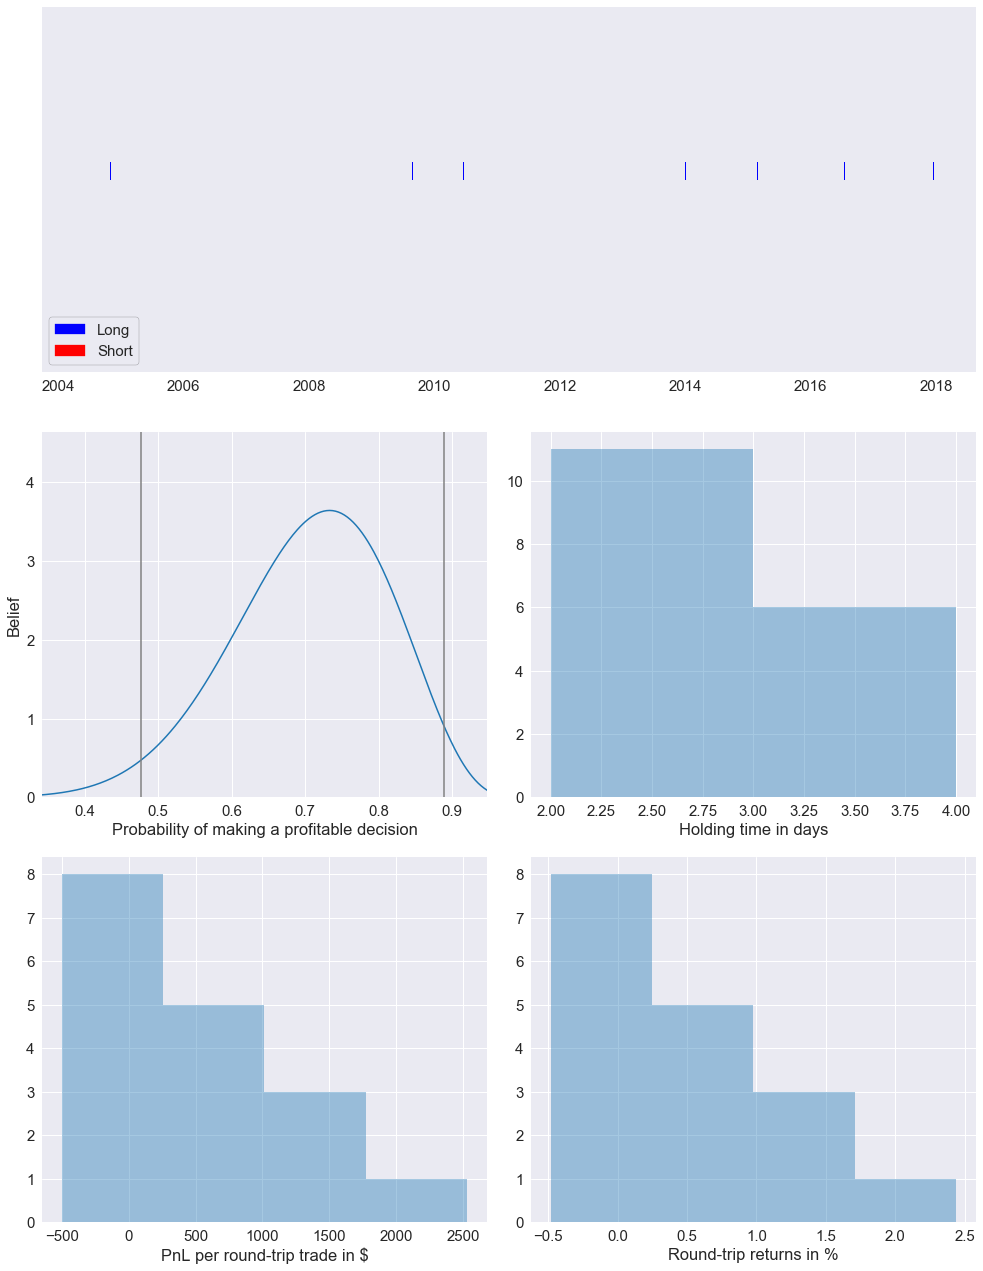

In [7]:
pf.create_full_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions,
                          round_trips=True)